<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install imbalanced-learn -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import time


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor  
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV, 
    train_test_split, 
    TimeSeriesSplit
)

from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose




In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
display(data.head())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Перевдем формат столбца datetime в datetime.

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим индекс таблицы равным столбцу datetime.

In [6]:
data.set_index('datetime', inplace=True)

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic

In [8]:
data.index.is_monotonic_increasing
print(data.index.is_monotonic_increasing)

True


Выполним ресемплирование данных по одному часу.


In [9]:
data.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


На этапе подготовки данных мы 
- поменяли формат данных столбца с датой в datetime;
- установили индексы таблицы равными столбцу datetime;
- проверили на монотонность и ресемплировали данные по 1 часу.

## Анализ

Посмотрим период, за который предоставили данные:

In [10]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Предоставлены даные за весну и лето (с 1 марта по 31 августа) 2018 года.

Построим график зависимости суммарного числа заказов в единицу времени (в данном случае - в час).

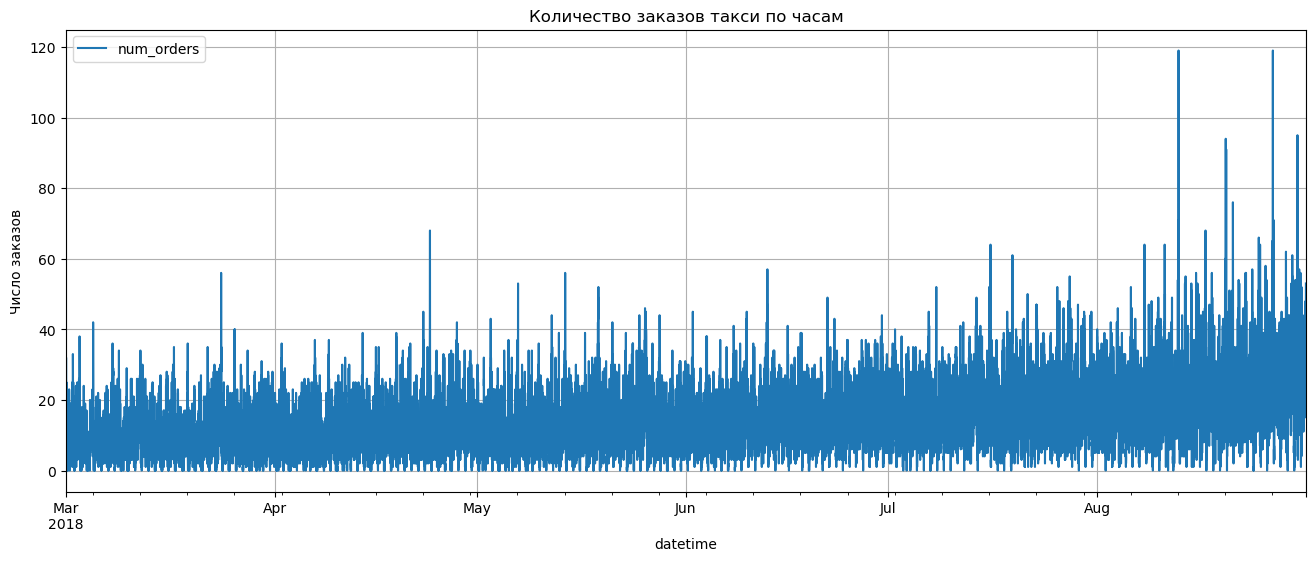

In [11]:
plt.figure(figsize=(16,6))
plt.title('Количество заказов такси по часам')
data.plot(ax=plt.gca())
plt.ylabel('Число заказов')
plt.grid(True);

На графике заметны тренд и пики, но анализировать и делать выводы проблематично. Построим график кользящего среднего, далее разложим временной ряд на тренд, сезонность, случайные колебания.

Построим график скользящего среднего, сделаем разбивку на неделю (интервал усреднения или окно равно 24*7).

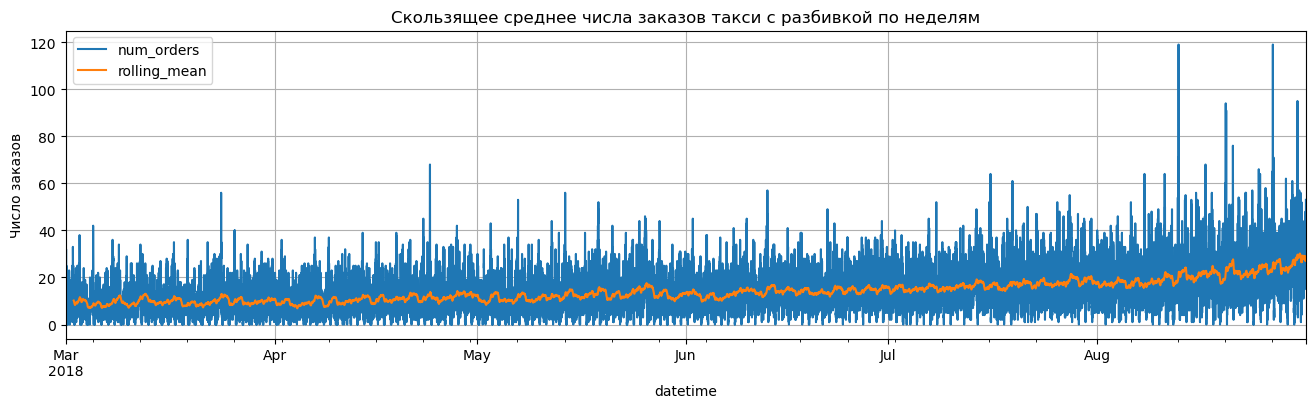

In [12]:
data['rolling_mean'] = data.rolling(24*7).mean()
plt.figure(figsize=(16,4))
plt.title('Скользящее среднее числа заказов такси с разбивкой по неделям')
data.plot(ax=plt.gca())
plt.grid(True)
plt.ylabel('Число заказов');

Разложим временной ряд на тренд, сезонность и случайный шум.

In [13]:
data = data.resample('1H').sum()
data.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,0.0
2018-03-01 01:00:00,85,0.0
2018-03-01 02:00:00,71,0.0
2018-03-01 03:00:00,66,0.0
2018-03-01 04:00:00,43,0.0


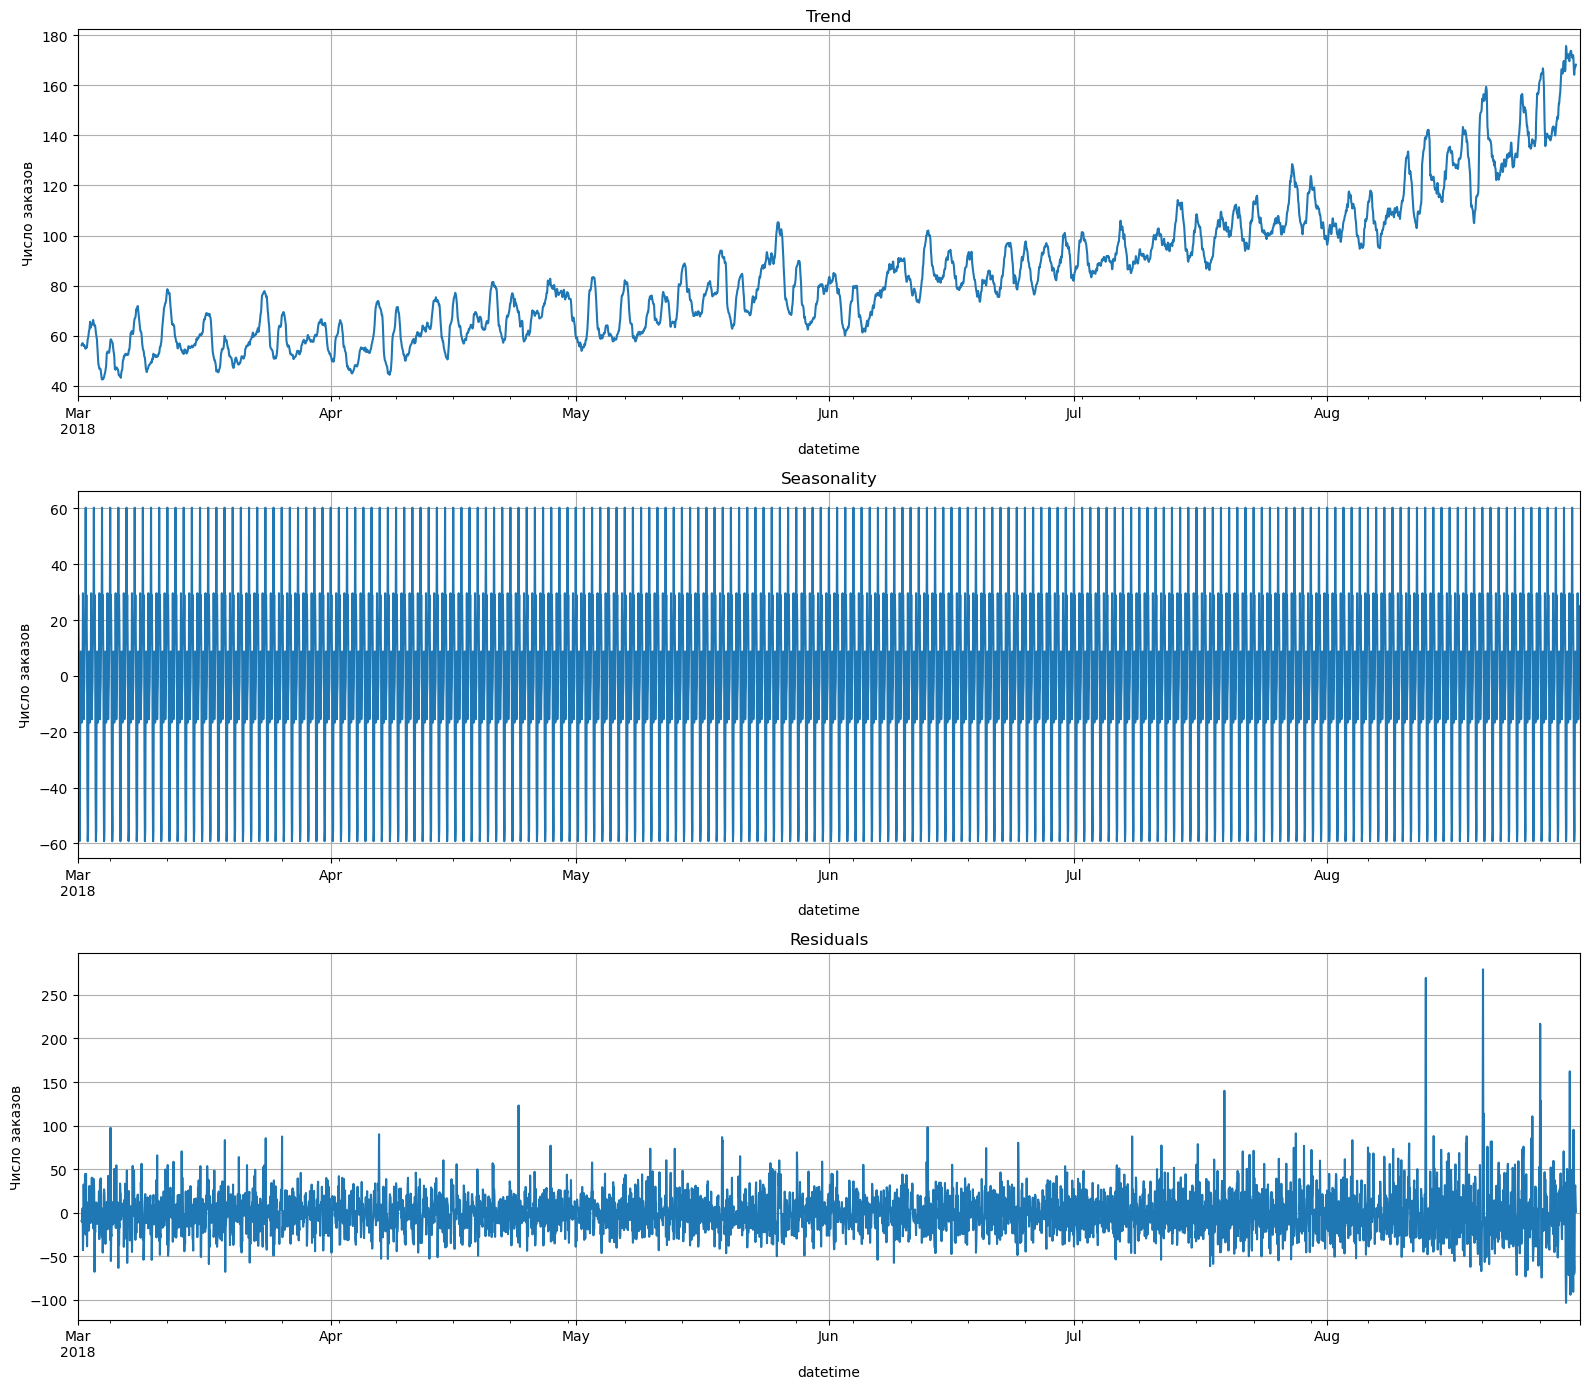

In [14]:
data = data.resample('1H').sum()
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(16, 14))

plt.subplot(311)
ax=plt.gca()
decomposed.trend.plot(ax=plt.gca()) # тренд
plt.title('Trend')
plt.ylabel('Число заказов')
plt.grid(True)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # сезонная составляющая
plt.title('Seasonality')
plt.ylabel('Число заказов')
plt.grid(True)

plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) # остатки
plt.title('Residuals')
plt.ylabel('Число заказов')
plt.grid(True)
plt.tight_layout()
#plt.show();

На графие trend видим плавный рост суточного количества заказов с марта по июнь, рост становится интенсивнее летом и достигает максимума за рассматриваемый период в августе. 

Компонента случайных колебаний в данных за весь период относительно стабильна, но есть несколько ощутимых пиков в августе.

Чтобы более наглядно изобразить сезонные колебания заказов, возьмем данные за короткие периоды августа: за период с 10 по 21 августа и за 2 дня.

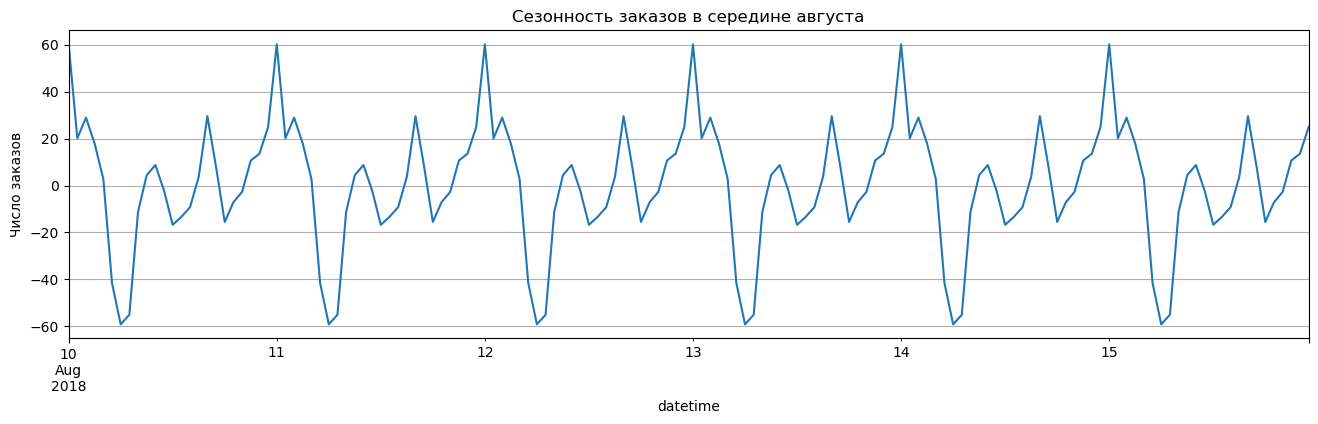

In [15]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в середине августа")
plt.ylabel('Число заказов')
decomposed.seasonal['2018-08-10':'2018-08-15'].plot(ax=plt.gca())
plt.grid(True)

На графике сезонности наблюдаем суточную цикличность числа заказов. Чтобы увидеть закономерности по часам, посмотрим на график сезонности за 2 дня.

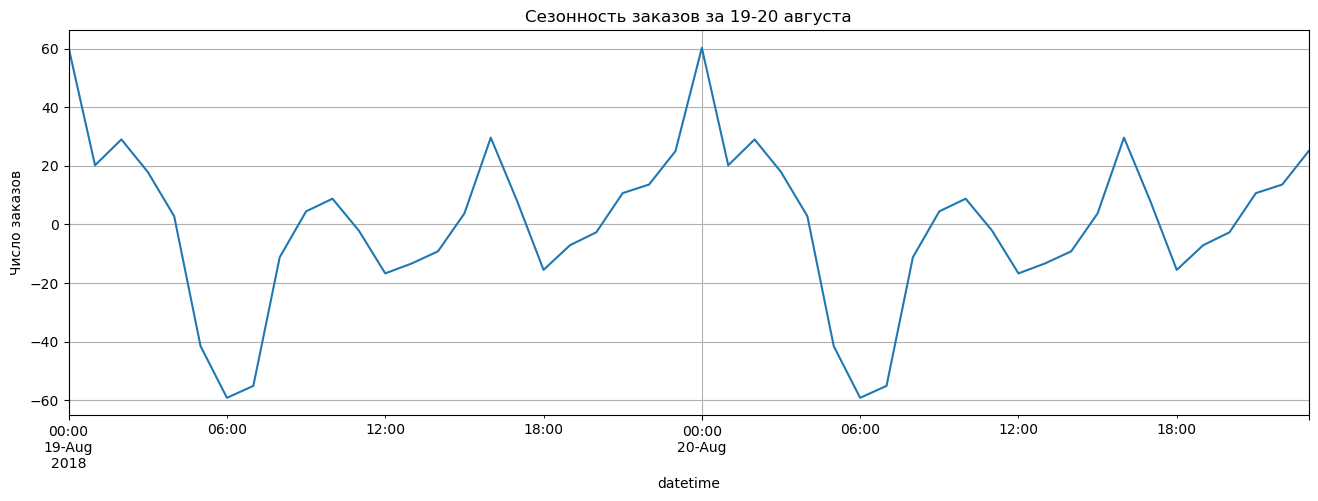

In [16]:
plt.figure(figsize=(16, 5))
plt.title("Сезонность заказов за 19-20 августа")
plt.ylabel('Число заказов')
decomposed.seasonal['2018-08-19':'2018-08-20'].plot(ax=plt.gca())
plt.grid(True)

К 6 утра число заказов достигает минимума, увеличивается к 11 часам утра, следующий пик в 17  часов вечера, к 18 число заказов падает, затем плавно растет, достигая максимума, к полуночи.

**Добавление новых признаков**

In [17]:
data.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,0.0
2018-03-01 01:00:00,85,0.0
2018-03-01 02:00:00,71,0.0
2018-03-01 03:00:00,66,0.0
2018-03-01 04:00:00,43,0.0


Создадим функцию для добавления новых признаков.

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy(deep = True)
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [19]:
data = data.drop(['rolling_mean'], axis = 1)

In [20]:
df = make_features(data, 168, 7)

C:\Users\babay\AppData\Local\Temp\ipykernel_696\860624748.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\babay\AppData\Local\Temp\ipykernel_696\860624748.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\babay\AppData\Local\Temp\ipykernel_696\860624748.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [21]:
df.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим датасет на обучающую и тестовую выборки, удалим пустые значения в обучающей выборке.

In [22]:
train, test = train_test_split(df, shuffle=False, test_size = 0.1)
train = train.dropna() #удалили Nan

features_train = train.drop(columns='num_orders')
target_train = train['num_orders']
features_test = test.drop(columns='num_orders')
target_test = test['num_orders']

print(f'Размер обучающей выборки - {target_train.shape[0]}')
print(f'Размер тестовой выборки - {target_test.shape[0]}')

Размер обучающей выборки - 3806
Размер тестовой выборки - 442


Масштабировать данные не нужно, т к нет данных, сильно отличающихся по масштабу (дни, часы). Кодировать нечего, категориальных признаков нет.

## Обучение

Инициализируем TimeSeriesSplit для разделения и перекрестной проверки временных рядов.

In [23]:
time_split = TimeSeriesSplit(n_splits=5)

Создадим функцию для анализа моделей, которая будет считать:

***1)*** Время обучения модели;

***2)*** Оптимальную комбинацию гиперпараметров с помощью GridSearch;

***3)*** Время предсказания модели

***4)*** Лучшую метрику RMSE. 

In [24]:
def model_analysis(model, parameters, features_train, target_train):
    start_time = time.time()
    grid = GridSearchCV(model, param_grid = parameters, 
                        cv=time_split,
                        n_jobs=-1,
                        scoring = 'neg_root_mean_squared_error')
    grid.fit(features_train, target_train)
    train_time = time.time() - start_time
    start_time = time.time()
    
    predict = grid.predict(features_train)
    predict_time = time.time() - start_time
    
    rmse = np.sqrt(mean_squared_error(target_train, predict))
    
    stat = [train_time, predict_time, grid.best_score_, grid.best_params_]

    return stat, grid

***Модель линейной регрессии***

In [25]:
linear_model = LinearRegression()

parameters = {'fit_intercept':[True,False], 
              'positive':[True,False]}

In [26]:
linear_stat, linear_grid = model_analysis(linear_model, parameters, features_train, target_train)

In [27]:
linear_stat

[2.592902183532715,
 0.0060002803802490234,
 -21.960474549689344,
 {'fit_intercept': False, 'positive': True}]

***Модель дерево решений***

In [28]:
tree_model = DecisionTreeRegressor(random_state = 42)

parameters = {'max_depth': range(4, 10, 1), 
              'min_samples_split': range(5, 12, 1),
              'min_samples_leaf': [1, 3, 5],
              'splitter': ['best', 'random']}

In [29]:
tree_stat, tree_grid = model_analysis(tree_model, parameters, features_train, target_train)

In [30]:
tree_stat

[21.567958116531372,
 0.0060002803802490234,
 -26.531703180472164,
 {'max_depth': 4,
  'min_samples_leaf': 5,
  'min_samples_split': 5,
  'splitter': 'best'}]

***Модель CatBoost***

In [31]:
catboost_model = CatBoostRegressor(random_state=42, silent=True)

params_catboost = {
     'learning_rate': [0.07],
    'iterations': range(20, 23, 1),
    'max_depth': range(3, 6, 1)
}

In [32]:
catboost_stat, catboost_grid = model_analysis(catboost_model, params_catboost,
                                              features_train, target_train)

In [33]:
catboost_stat

[5.077292203903198,
 0.004007577896118164,
 -26.487941613174808,
 {'iterations': 22, 'learning_rate': 0.07, 'max_depth': 5}]

***Модель LightGBM***

In [34]:
lgbm_model = LGBMRegressor(random_state=42)
param_lgbm = {
    'n_estimators': range(42, 45, 1),
    'learning_rate': [0.11]
}

In [35]:
lgbm_stat, lgbm_grid = model_analysis(lgbm_model, param_lgbm,
                                      features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31509
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 172
[LightGBM] [Info] Start training from score 79.352864


In [36]:
lgbm_stat

[4.362997531890869,
 0.009999990463256836,
 -23.17037969345549,
 {'learning_rate': 0.11, 'n_estimators': 42}]

***Сравнение результатов***

In [37]:
analysis_data= pd.DataFrame([linear_stat, tree_stat, catboost_stat, lgbm_stat], 
             columns=['Время обучения', 'Время предсказания', 'RMSE', 'Лучшие параметры'], 
                      index=['linear_stat', 'tree_stat', 'catboost_stat', 'lgbm_stat'])
analysis_data


,Время обучения,Время предсказания,RMSE,Лучшие параметры
linear_stat,2.592902,0.006000,-21.960475,"{'fit_intercept': False, 'positive': True}"
tree_stat,21.567958,0.006000,-26.531703,"{'max_depth': 4, 'min_samples_leaf': 5, 'min_s..."
catboost_stat,5.077292,0.004008,-26.487942,"{'iterations': 22, 'learning_rate': 0.07, 'max..."
lgbm_stat,4.362998,0.010000,-23.170380,"{'learning_rate': 0.11, 'n_estimators': 42}"


Лучшие результаты (времея обучения, предсказания, метрика RMSE) - у модели линейной регрессии: RMSE 22, время обучения 5,8 секунд, время предсказания 0,004 секунды. Метрика RMSE и время обучения других моделей сильно хуже. 

Рекомендую модель линейной регрессии для предсказания числа заказов такси на следующий час.

## Тестирование

Протестируем лучшую модель на тестовой выборке.

In [38]:
linear_predict = linear_grid.predict(features_test)

In [39]:
linear_rmse = np.sqrt(mean_squared_error(target_test, linear_predict))

In [40]:
linear_rmse

34.844166242987804

На тестовой выборке модель линейной регрессии показала метрику RMSE  34,8, что соответствует требованиям заказчика (RMSE не более 48).

Посмотрим на графике соотношение реальных значений и предсказанных лучшей моделью.

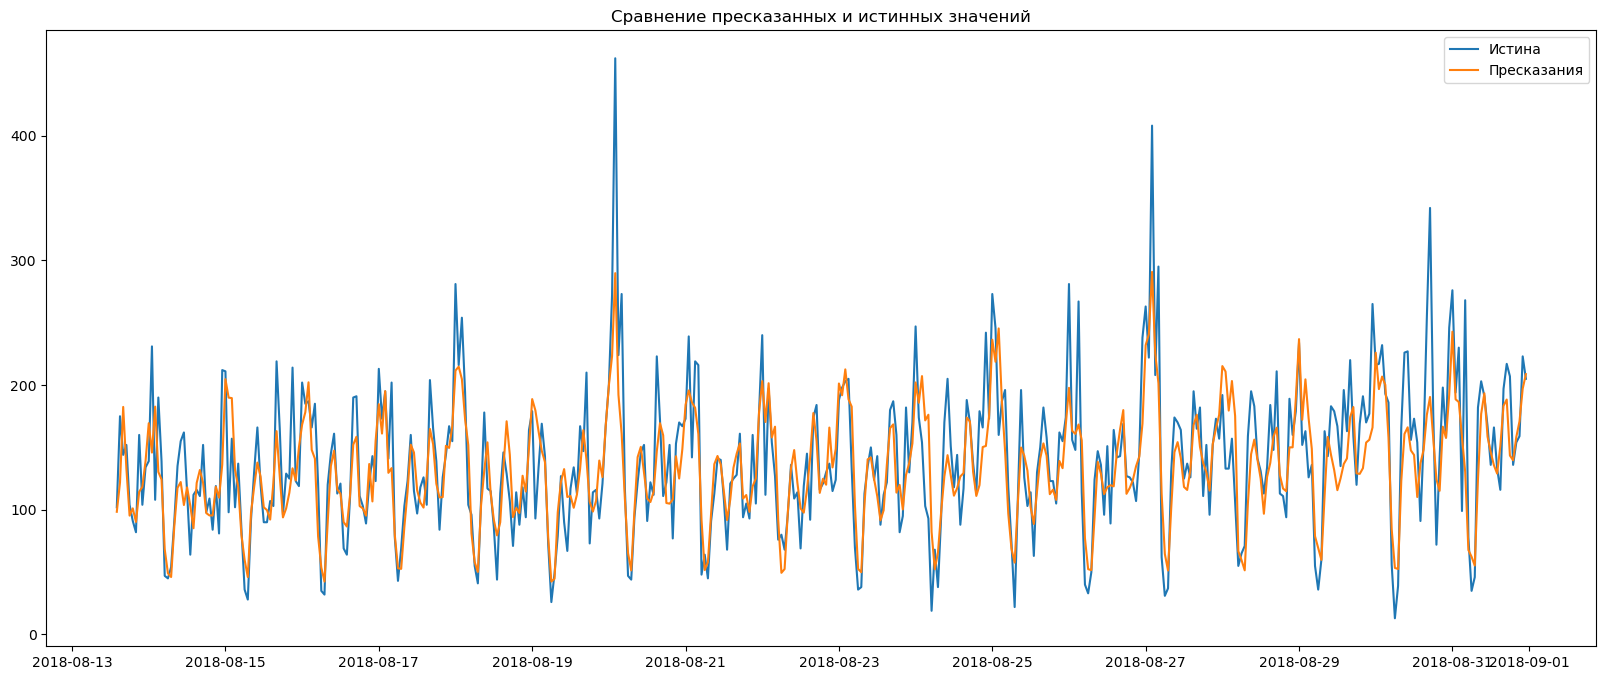

In [41]:
plt.figure(figsize=(20,8))

plt.plot(target_test, label='Истина')
plt.plot(target_test.index, linear_predict, label='Пресказания')

plt.title('Сравнение пресказанных и истинных значений')
plt.legend();

Видим, что в целом предсказания модели бликзки к реальным данным, но в моменты пиковых нагрузок (резких скачков числа заказов) предсказания модели занижены.

## Выводы по проекту

В рамках проекта выполнены следующие шаги:

***1)*** Проверка на монотонность, рассемплирование временного ряда по часу, выявлены тренды и сезонность, добавлены новые признаки.

***2)*** Обучены моделями линейной регрессии, дерева решений, CatBoostRegressor и LGBMRegressor. Подобраны лучшие гиперпараметры данных моделей.

***3)*** По итогам сравнения лучшие результаты (время обучения, предсказания, метрика RMSE) - у модели линейной регрессии: RMSE 22, время обучения 5,8 секунд, время предсказания 0,004 секунды. Метрика RMSE и время обучения других моделей сильно хуже.

***4)*** Проведено тестирование лучшей модели на тестовой выборке. На тестовой выборке модель линейной регрессии показала метрику RMSE 34,8, что соответствует требованиям заказчика (RMSE не более 48).

***5)*** При визуализации результатов предсказанных моделью и реальных данных видим, что предсказания модели почти всегда близки к реальным данным, кроме трех моментов времени пиковых загрузок.